<a href="https://colab.research.google.com/github/vonnan/IBM-capstone-project/blob/main/DimSum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Neighborhood Battles


### Introduction and Background

A friend wants to start her own dimsum restaurant in one of neighborhood in Edison. She hired me as her data scientist to help her decide which neighborhood/location she should open the business.

Based on my research,  Edison is the fifth-most populous municipality in New Jersey, with population a little more than 100K, 29.27% Asian are residing in Edison township.  It has many Asian supermarkets that Asian residents go to every week. There are about at least 25 (popular) Chinese restaurants in town, only one is dimsum place. 

Edison is a huge town with a total area of 30.69 square miles (79.49 km2) and 31 nsections/neighborhoods. We want to select the most popular place for restaurant business.

### Data used in this report

Edison neighborhood data is webscraped from wiki link with neighborhood names, lat/lon

Edison Venues is to make calls to Foursquare API for exploring the neighborhood

### Methodology

1. Dataframe: Edison ----Web Scraping Edison neighborhood data with neighborhood name, latitude/longitude
(Need some data cleaning for the data)

2. Dataframe: Edison (with Geo Label added)----Using unsupervised KMeans clustering and lat/lon only, divide Edison into 4 big clusters (geogrphically divided), adding Geo Labels

3. Dataframe: Edison_venues----Make calls to the Foursquare API for exploring each neighborhood, finding the top 100 venues within 1000 meter radius of each neighborhood.

4. Dataframe: Edison_onehot---Using pd.get_dummies to change the venue categories into numerical values

5. Dataframe: Edison_grouped---Using groupby to find for each neighborhood the mean value for each categories, the data frame is Edison

6. Dataframe: Edison_top_venues----In the mean time, by sort_values, find the top 10 popular venues for each neighborhood. 

7. Dataframe: Edison_merge---- Edison_top_venues added with Venue Label, then merged into dataframe of Edison on "Neighborhood" 

---Using unsupervized KMeans clustering on dataframe of Edison_grouped to get the clustering based on venues. The Venue Label is added based on the clustering result into Edison_top_venues and then it is merged with dataframe of Edison on "Neighborhood".

The reason to use unsupervised KMeans clustering is because we want to divide Edison into regions based on their venues. From our business suceed, we want to put it into the potenital restaurant neighborhood, but not next door to another similar Chinese breakfast place.

8. Dataframe: Edison_Chinatown: We found one of the cluster based on "Venue Label" has specialty on Asian restaurants (Chinese, Indian, Korean, Malay, Mongolia, Japanese etc), Asian supermarkets, Asian dessert shop(Bakery/Bubble Tea/Frozen Yogurt etc). The cluster includes 9 neighborhoods. We will focus on this dataframe for future analysis.

9. Dataframe: Edison_Chinatown_venues: 

One more time using KMeans clustering. Stelton neighborhood has the most Chinese restaurant, Asian supermarket etc.

Results section where you discuss the results.
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
Conclusion section where you conclude the report.


### Data Visualizetion on Results


1. Edison_map: Use folium.map to draw Edison on the map

2. Edison_map (neighborhoods added with different colors based on Geo Label) Use folium.CircleMarker for all the neighborhoods in Edison,  use different colors for different neighborhood clusters based on Geo Label

3.  Edison_map (neighborhoods added with different colors based on Venue Label) Use folium.CircleMarker for all the neighborhoods, based on Venue Label

4. Edison_Chinatown_map: focused on the venue cluster 0, which I called it Edison Chinatown.

5. Edison_Chinatown_map (Added Asian restaurants, Asian dessert shop and Asian supermarket, Breakfast)

6. Showing the seaborn countplot on the main "EAT" related venues. There are seven venues that can eat breakfast in Stelton neighborhood. We also draw the countplot for the breakfast type venue, none of them are Asian types.


### Conclusion:

1. Chinaese restaurants, dessert shops are clustered in Stelton Neighborhood near H-Mart

2. In that regions there are only three breakfast places that can eat breakfast (Donkin Donuts, Bagel Shop, Burger King), American/fastfood style.

3. The best spot to open a dim-sum place is in that region Stelton Neighborhood near H-Mart, where people can eat breakfast first, then go shopping etc.










In [85]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


###Dataframe: Edison ----Web Scraping Edison neighborhood data with neighborhood name, latitude/longitude (Need some data cleaning for the data)

In [86]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Edison,_New_Jersey")
cols = ["Name", "Coordinate", "Notes"]
Edison = df[0][cols].copy()
Edison.head()
Edison.iloc[18]["Coordinate"] = "40°31′24″N 74°21′28″W\ufeff / \ufeff40.522964°N 74.411674°W"
def getLatLon(df):
  lat = []
  lng = []
  for i in range(len(df)):
    row = df.loc[i]  
    latlon =row["Coordinate"][:-2].split("/ \ufeff")[-1].split("°N ")
    lat.append(latlon[0])
    lng.append(latlon[1])
  return lat, lng
lat,lng = getLatLon(Edison)
Edison["Latitude"], Edison["Longitude"] = getLatLon(Edison)
Edison.drop(columns = "Coordinate", inplace = True)
Edison["Latitude"] = Edison["Latitude"].astype("float")
Edison["Longitude"] = ("-"+Edison["Longitude"]).astype("float")
Edison.rename(columns= {"Name" : "Neighborhood"}, inplace = True)
Edison

,Neighborhood,Notes,Latitude,Longitude
0,Bonhamtown,The neighborhood began as colonial village tha...,40.523330,-74.357780
1,Camp Kilmer site,Abutting the Livingston Campus (Rutgers Univer...,40.520830,-74.413060
2,Clara Barton,Named for Clara Barton. Located in the eastern...,40.534170,-74.339440
3,Greensand,"Site of the Kin-Buc Landfill, where Edmonds Cr...",40.491670,-74.387220
4,Haven Homes,NaN,40.509440,-74.406390
5,Lahiere,Lahiere is a neighbohood in the Stelton sectio...,40.518890,-74.402500
6,Lincoln Park,"For other places named Lincoln Park, New Jerse...",40.518890,-74.402500
7,Lindenau,Lindenauis a neighborhood of the Stelton secti...,40.515000,-74.411110
8,Martins Landing,Located on the northern banks of the Raritan R...,40.493060,-74.399720
9,Menlo Park,"Menlo Park is where, in 1876, Thomas Edison se...",40.565000,-74.337500


###Edison_Map

In [163]:
address = "Edison, NJ"
location = Nominatim(user_agent= "edison_explorer").geocode(address)
lat = location.latitude
lng = location.longitude
Edison_map = folium.Map([lat, lng], zoom_start= 12.5)



### Use Geolocation to divide the neighborhoods in Edison (KMeans Clustering)

In [134]:
X = Edison[["Latitude", "Longitude"]]
KM = KMeans(n_clusters= 4, n_init = 12, random_state= 0)
KM.fit(X)
Edison["Geo Label"] = KM.labels_
colors = ["red", "blue", "green", "purple"]
for name, lat, lng, geo_label in zip(Edison["Neighborhood"], Edison["Latitude"], Edison["Longitude"], Edison["Geo Label"]):
  label = name
  color = colors[geo_label]
  folium.CircleMarker(
      [lat, lng],
      radius = 10,
      fill = True,
      popup = label,
      color = color,
      fill_color = color,
      fill_opacity = 0.3
  ).add_to(Edison_map)

#Edison.rename(columns= {"Name" : "Neighborhood"}, inplace = True)


In [135]:
Edison_map

###Get the venues for the neighborhood, radius = 1000 and limit = 100

### We are going to collect all the venues from the FourSquare

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format( CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

In [136]:
CLIENT_ID = 'KWTBOAQUOFKZSP5QHAZ530MZ5WKAUPBPCFZKQJNVEM5EJV1R' # your Foursquare ID
CLIENT_SECRET = 'LP251NSOTLWM5PWMYKWNCRMMFSSRRZC5D4PHSGLASZ1GXK5T' # your Foursquare Secret
ACCESS_TOKEN = '2NX33SVZLUCMUQOF01CKEZ2PHKA3VAR4NPDCGD4DWOMNVTHP' # your FourSquare Access Token
VERSION = '20201205'
LIMIT = 100
radius = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: KWTBOAQUOFKZSP5QHAZ530MZ5WKAUPBPCFZKQJNVEM5EJV1R
CLIENT_SECRET: LP251NSOTLWM5PWMYKWNCRMMFSSRRZC5D4PHSGLASZ1GXK5T


###Dataframe: Edison_venues----Make calls to the Foursquare API for exploring each neighborhood, finding the top 100 venues within 1000 meter radius of each neighborhood.


In [137]:
def getNearByVenues(names, lats, lngs, radius = 1000):
  venue_list = []
  for lat,lng,name in zip(lats, lngs, names):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      CLIENT_ID, 
      CLIENT_SECRET, 
      VERSION, 
      lat, 
      lng, 
      radius, 
      LIMIT)
    results = requests.get(url).json()["response"]["groups"][0]["items"]
    venue_list.append([(
        name,
        lat,
        lng,
        v["venue"]["name"],
        v["venue"]["location"]["lat"],
        v["venue"]["location"]["lng"],
        v["venue"]["categories"][0]["name"]) for v in results]
    )
  venue_df = pd.DataFrame([item for v in venue_list for item in v])
  venue_df.columns = [
                      "Neighborhood",
                      "Neighborhood Latitude",
                      "Neighborhood Longitude",
                      "Venue Name",
                      "Venue Latitude",
                      "Venue Longitude",
                      "Venue Category"
  ]
  return venue_df

Edison_venues = getNearByVenues(Edison["Neighborhood"], Edison["Latitude"], Edison["Longitude"], radius = 1000)

###Dataframe: Edison_onehot---Using pd.get_dummies to change the venue categories into numerical values

###Dataframe: Edison_grouped---Using groupby to find for each neighborhood the mean value for each categories, the data frame is Edison


In [138]:
Edison_onehot = Edison_venues["Neighborhood"]
Edison_onehot = pd.concat([Edison_onehot, pd.get_dummies(Edison_venues["Venue Category"], prefix= "", prefix_sep="")], axis =1)
Edison_onehot.head()
Edison_grouped = Edison_onehot.groupby("Neighborhood").mean()
Edison_grouped.iloc[0].sort_values(ascending = False).head(10).index.values

array(['Furniture / Home Store', 'Park', 'Pizza Place', 'Sandwich Place',
       'Hotel', 'Gym / Fitness Center', 'Pet Store', 'Salon / Barbershop',
       'Chinese Restaurant', 'Rental Car Location'], dtype=object)

### Dataframe: Edison_top_venues----In the mean time, by sort_values, find the top 10 popular venues for each neighborhood.


In [139]:
def get_top_venues(row, num_top):
  return row.sort_values(ascending = False).head(num_top).index.values
get_top_venues(Edison_grouped.iloc[0], 10)

array(['Furniture / Home Store', 'Park', 'Pizza Place', 'Sandwich Place',
       'Hotel', 'Gym / Fitness Center', 'Pet Store', 'Salon / Barbershop',
       'Chinese Restaurant', 'Rental Car Location'], dtype=object)

In [140]:
num_top = 10
ind = ["st", "nd", "rd"] # 1st, 2nd, 3rd
columns = ["Neighborhood", "Venue Label"]
for i in range(num_top):
  if i<=2:
    columns.append("{}{} Most Popular Venue".format(i+1, ind[i]))
  else:
    columns.append("{}th Most Popular Venue".format(i+1))
Edison_top_venues = pd.DataFrame(columns = columns)
Edison_top_venues["Neighborhood"] = Edison_grouped.index.values
for i in range(len(Edison_grouped)):
  row = Edison_grouped.iloc[i,:].T
  Edison_top_venues.iloc[i, 2:] = get_top_venues(row, 10)
Edison_top_venues

,Neighborhood,Venue Label,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
0,Bonhamtown,NaN,Furniture / Home Store,Park,Pizza Place,Sandwich Place,Hotel,Gym / Fitness Center,Pet Store,Salon / Barbershop,Chinese Restaurant,Rental Car Location
1,Camp Kilmer site,NaN,Spa,Korean Restaurant,Bakery,Hotpot Restaurant,Indian Restaurant,Dentist's Office,Deli / Bodega,BBQ Joint,Playground,Chinese Restaurant
2,Clara Barton,NaN,Deli / Bodega,Pharmacy,Pizza Place,Convenience Store,Farmers Market,American Restaurant,Grocery Store,Mobile Phone Shop,Café,Chinese Restaurant
3,Greensand,NaN,Business Service,Lake,Auto Garage,Rental Service,Fast Food Restaurant,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food & Drink Shop
4,Haven Homes,NaN,Chinese Restaurant,Korean Restaurant,Bakery,Dessert Shop,Bubble Tea Shop,Wings Joint,Spa,Pharmacy,Hookah Bar,Supermarket
5,Lahiere,NaN,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
6,Lincoln Park,NaN,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
7,Lindenau,NaN,Chinese Restaurant,Spa,Dessert Shop,Bakery,Indian Restaurant,Bubble Tea Shop,Construction & Landscaping,Korean Restaurant,Asian Restaurant,Bank
8,Martins Landing,NaN,Mexican Restaurant,Pharmacy,Deli / Bodega,Sandwich Place,Event Space,Fried Chicken Joint,Food & Drink Shop,Food,Fast Food Restaurant,Farmers Market
9,Menlo Park,NaN,Indian Restaurant,Pizza Place,Grocery Store,History Museum,Fast Food Restaurant,Train,Market,Gas Station,Donut Shop,State / Provincial Park


### KMeans Clustering based on Venues

In [164]:
KM = KMeans(n_clusters = 6, n_init = 12, random_state = 0)
KM.fit(Edison_grouped)
Edison_top_venues["Venue Label"] = KM.labels_
Edison_top_venues.sort_values("Venue Label")

,Neighborhood,Venue Label,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
30,Washington Park,0,Chinese Restaurant,Bakery,Korean Restaurant,Dessert Shop,Asian Restaurant,Bubble Tea Shop,Pharmacy,Farmers Market,Fast Food Restaurant,Sandwich Place
7,Lindenau,0,Chinese Restaurant,Spa,Dessert Shop,Bakery,Indian Restaurant,Bubble Tea Shop,Construction & Landscaping,Korean Restaurant,Asian Restaurant,Bank
6,Lincoln Park,0,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
5,Lahiere,0,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
27,Stelton,0,Bakery,Dessert Shop,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Sandwich Place,Spa,Fast Food Restaurant,Bank,Supermarket
3,Greensand,0,Business Service,Lake,Auto Garage,Rental Service,Fast Food Restaurant,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food & Drink Shop
1,Camp Kilmer site,0,Spa,Korean Restaurant,Bakery,Hotpot Restaurant,Indian Restaurant,Dentist's Office,Deli / Bodega,BBQ Joint,Playground,Chinese Restaurant
4,Haven Homes,0,Chinese Restaurant,Korean Restaurant,Bakery,Dessert Shop,Bubble Tea Shop,Wings Joint,Spa,Pharmacy,Hookah Bar,Supermarket
18,Oak Tree Road,0,Business Service,Dentist's Office,Playground,Indian Restaurant,Deli / Bodega,Convenience Store,Spa,Lawyer,Yoga Studio,Farmers Market
28,Valentine,1,Hotel,Pizza Place,American Restaurant,Donut Shop,Convenience Store,Deli / Bodega,Chinese Restaurant,Bar,Miscellaneous Shop,Café


### Dataframe: Edison_merge---- Edison_top_venues added with Venue Label, then merged into dataframe of Edison on "Neighborhood" 

In [165]:
Edison_merge = Edison.merge(right = Edison_top_venues, on = "Neighborhood")
Edison_merge.sort_values("Venue Label", inplace= True)
Edison_merge
color_venue = ["red", "blue", "green", "yellow", "purple", "pink"]

for name, lat, lng, lbl in zip(Edison_merge["Neighborhood"], Edison_merge["Latitude"], Edison_merge["Longitude"], Edison_merge["Venue Label"]):
  color = color_venue[lbl]
  folium.CircleMarker(
      [lat, lng],
      popup = name,
      fill = True,
      color = color,
      fill_color = color,
      radius = 12,
      fill_opacity = 0.5
  ).add_to(Edison_map)
Edison_merge[Edison_merge["Venue Label"]==0]["Neighborhood"].tolist()

['Washington Park',
 'Lindenau',
 'Lincoln Park',
 'Lahiere',
 'Stelton',
 'Greensand',
 'Camp Kilmer site',
 'Haven Homes',
 'Oak Tree Road']

In [166]:
Edison_map


In [98]:
Edison_merge


,Neighborhood,Notes,Latitude,Longitude,Geo Label,Venue Label,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
30,Washington Park,Washington Park is to the east of Stelton.,40.513890,-74.398330,1,0,Chinese Restaurant,Bakery,Korean Restaurant,Dessert Shop,Asian Restaurant,Bubble Tea Shop,Pharmacy,Farmers Market,Fast Food Restaurant,Sandwich Place
7,Lindenau,Lindenauis a neighborhood of the Stelton secti...,40.515000,-74.411110,1,0,Chinese Restaurant,Spa,Dessert Shop,Bakery,Indian Restaurant,Bubble Tea Shop,Construction & Landscaping,Korean Restaurant,Asian Restaurant,Bank
6,Lincoln Park,"For other places named Lincoln Park, New Jerse...",40.518890,-74.402500,1,0,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
5,Lahiere,Lahiere is a neighbohood in the Stelton sectio...,40.518890,-74.402500,1,0,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
27,Stelton,One the oldest parts of Edison.,40.514170,-74.403610,1,0,Bakery,Dessert Shop,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Sandwich Place,Spa,Fast Food Restaurant,Bank,Supermarket
3,Greensand,"Site of the Kin-Buc Landfill, where Edmonds Cr...",40.491670,-74.387220,1,0,Business Service,Lake,Auto Garage,Rental Service,Fast Food Restaurant,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food & Drink Shop
1,Camp Kilmer site,Abutting the Livingston Campus (Rutgers Univer...,40.520830,-74.413060,1,0,Spa,Korean Restaurant,Bakery,Hotpot Restaurant,Indian Restaurant,Dentist's Office,Deli / Bodega,BBQ Joint,Playground,Chinese Restaurant
4,Haven Homes,NaN,40.509440,-74.406390,1,0,Chinese Restaurant,Korean Restaurant,Bakery,Dessert Shop,Bubble Tea Shop,Wings Joint,Spa,Pharmacy,Hookah Bar,Supermarket
18,Oak Tree Road,Shopping strip runs through Edison and neighbo...,40.522964,-74.411674,1,0,Business Service,Dentist's Office,Playground,Indian Restaurant,Deli / Bodega,Convenience Store,Spa,Lawyer,Yoga Studio,Farmers Market
28,Valentine,Valentine is adjacent to the Fords section of ...,40.530830,-74.325560,2,1,Hotel,Pizza Place,American Restaurant,Donut Shop,Convenience Store,Deli / Bodega,Chinese Restaurant,Bar,Miscellaneous Shop,Café


###Edison_Chinatown

In [167]:
Edison_Chinatown = Edison_merge[Edison_merge["Venue Label"] == 0]
Edison_Chinatown

,Neighborhood,Notes,Latitude,Longitude,Geo Label,Venue Label,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
30,Washington Park,Washington Park is to the east of Stelton.,40.513890,-74.398330,1,0,Chinese Restaurant,Bakery,Korean Restaurant,Dessert Shop,Asian Restaurant,Bubble Tea Shop,Pharmacy,Farmers Market,Fast Food Restaurant,Sandwich Place
7,Lindenau,Lindenauis a neighborhood of the Stelton secti...,40.515000,-74.411110,1,0,Chinese Restaurant,Spa,Dessert Shop,Bakery,Indian Restaurant,Bubble Tea Shop,Construction & Landscaping,Korean Restaurant,Asian Restaurant,Bank
6,Lincoln Park,"For other places named Lincoln Park, New Jerse...",40.518890,-74.402500,1,0,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
5,Lahiere,Lahiere is a neighbohood in the Stelton sectio...,40.518890,-74.402500,1,0,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
27,Stelton,One the oldest parts of Edison.,40.514170,-74.403610,1,0,Bakery,Dessert Shop,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Sandwich Place,Spa,Fast Food Restaurant,Bank,Supermarket
3,Greensand,"Site of the Kin-Buc Landfill, where Edmonds Cr...",40.491670,-74.387220,1,0,Business Service,Lake,Auto Garage,Rental Service,Fast Food Restaurant,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food & Drink Shop
1,Camp Kilmer site,Abutting the Livingston Campus (Rutgers Univer...,40.520830,-74.413060,1,0,Spa,Korean Restaurant,Bakery,Hotpot Restaurant,Indian Restaurant,Dentist's Office,Deli / Bodega,BBQ Joint,Playground,Chinese Restaurant
4,Haven Homes,NaN,40.509440,-74.406390,1,0,Chinese Restaurant,Korean Restaurant,Bakery,Dessert Shop,Bubble Tea Shop,Wings Joint,Spa,Pharmacy,Hookah Bar,Supermarket
18,Oak Tree Road,Shopping strip runs through Edison and neighbo...,40.522964,-74.411674,1,0,Business Service,Dentist's Office,Playground,Indian Restaurant,Deli / Bodega,Convenience Store,Spa,Lawyer,Yoga Studio,Farmers Market


###Visualization

In [173]:
Edison_Chinatown_map = folium.Map([40.514170, -74.403610], zoom_start= 15)
for name, lat, lng, lbl in zip(Edison_Chinatown["Neighborhood"], Edison_Chinatown["Latitude"], Edison_Chinatown["Longitude"], Edison_Chinatown["Venue Label"]):
  color = color_venue[lbl]
  folium.CircleMarker(
      [lat, lng],
      popup = name,
      fill = True,
      color = color,
      fill_color = color,
      radius = 12,
      fill_opacity = 0.3
  ).add_to(Edison_Chinatown_map)


In [169]:
names = Edison_Chinatown["Neighborhood"].tolist()
Edison_Chinatown_grouped = pd.DataFrame(columns= Edison_grouped.columns, index = names)
for name in names:
  Edison_Chinatown_grouped.loc[name, :] = Edison_grouped.loc[name, :]
X = Edison_Chinatown_grouped.astype("float")



In [171]:
KM = KMeans(n_clusters = 6, n_init=12)
KM.fit(X)
print(KM.labels_)
Edison_Chinatown["Venue Label"] = KM.labels_

Edison_Chinatown.sort_values("Venue Label", inplace= True)
Edison_Chinatown

[0 4 5 5 4 1 3 0 2]


,Neighborhood,Notes,Latitude,Longitude,Geo Label,Venue Label,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
30,Washington Park,Washington Park is to the east of Stelton.,40.513890,-74.398330,1,0,Chinese Restaurant,Bakery,Korean Restaurant,Dessert Shop,Asian Restaurant,Bubble Tea Shop,Pharmacy,Farmers Market,Fast Food Restaurant,Sandwich Place
6,Lincoln Park,"For other places named Lincoln Park, New Jerse...",40.518890,-74.402500,1,0,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
7,Lindenau,Lindenauis a neighborhood of the Stelton secti...,40.515000,-74.411110,1,1,Chinese Restaurant,Spa,Dessert Shop,Bakery,Indian Restaurant,Bubble Tea Shop,Construction & Landscaping,Korean Restaurant,Asian Restaurant,Bank
5,Lahiere,Lahiere is a neighbohood in the Stelton sectio...,40.518890,-74.402500,1,2,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Dessert Shop,Bakery,Bank,Fast Food Restaurant,Malay Restaurant,Lawyer,Bubble Tea Shop
27,Stelton,One the oldest parts of Edison.,40.514170,-74.403610,1,3,Bakery,Dessert Shop,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Sandwich Place,Spa,Fast Food Restaurant,Bank,Supermarket
4,Haven Homes,NaN,40.509440,-74.406390,1,4,Chinese Restaurant,Korean Restaurant,Bakery,Dessert Shop,Bubble Tea Shop,Wings Joint,Spa,Pharmacy,Hookah Bar,Supermarket
1,Camp Kilmer site,Abutting the Livingston Campus (Rutgers Univer...,40.520830,-74.413060,1,4,Spa,Korean Restaurant,Bakery,Hotpot Restaurant,Indian Restaurant,Dentist's Office,Deli / Bodega,BBQ Joint,Playground,Chinese Restaurant
3,Greensand,"Site of the Kin-Buc Landfill, where Edmonds Cr...",40.491670,-74.387220,1,5,Business Service,Lake,Auto Garage,Rental Service,Fast Food Restaurant,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food & Drink Shop
18,Oak Tree Road,Shopping strip runs through Edison and neighbo...,40.522964,-74.411674,1,5,Business Service,Dentist's Office,Playground,Indian Restaurant,Deli / Bodega,Convenience Store,Spa,Lawyer,Yoga Studio,Farmers Market


In [175]:
color_venue =["blue", "green","purple", "red", "yellow", "grey"]
for name, lat, lng, lbl in zip(Edison_Chinatown["Neighborhood"], Edison_Chinatown["Latitude"], Edison_Chinatown["Longitude"], Edison_Chinatown["Venue Label"]):
  color = color_venue[lbl]
  folium.CircleMarker(
      [lat, lng],
      popup = name,
      fill = True,
      color = color,
      fill_color = color,
      radius = 12,
      fill_opacity = 0.3
  ).add_to(Edison_Chinatown_map)

Edison_Chinatown_map

In [104]:
Edison_Chinatown_venues = Edison_venues[Edison_venues["Neighborhood"].isin(Edison_Chinatown["Neighborhood"])].reset_index(drop = True)
len(Edison_Chinatown_venues["Neighborhood"].unique())
Edison_Chinatown["Neighborhood"].unique()
Edison_Chinatown_venues["Venue Category"].value_counts()
Edison_Chinatown_venues["Venue Category"].value_counts().sort_index().index.values

array(['Arts & Crafts Store', 'Asian Restaurant', 'Auto Dealership',
       'Auto Garage', 'Automotive Shop', 'BBQ Joint', 'Bagel Shop',
       'Bakery', 'Bank', 'Baseball Field', 'Breakfast Spot',
       'Bubble Tea Shop', 'Buffet', 'Business Service',
       'Chinese Restaurant', 'Coffee Shop', 'Construction & Landscaping',
       'Convenience Store', 'Cosmetics Shop', 'Deli / Bodega',
       "Dentist's Office", 'Department Store', 'Dessert Shop',
       'Dim Sum Restaurant', 'Diner', 'Discount Store', 'Donut Shop',
       'Farmers Market', 'Fast Food Restaurant', 'Frozen Yogurt Shop',
       'Furniture / Home Store', 'Gas Station', 'Grocery Store',
       'Gym / Fitness Center', 'Heliport', 'High School', 'Hookah Bar',
       'Hotpot Restaurant', 'IT Services', 'Ice Cream Shop',
       'Indian Restaurant', 'Italian Restaurant', 'Kids Store',
       'Korean Restaurant', 'Lake', 'Lawyer', 'Malay Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Miscellaneou

[‘red’, ‘blue’, ‘green’, ‘purple’, ‘orange’, ‘darkred’,
’lightred’, ‘beige’, ‘darkblue’, ‘darkgreen’, ‘cadetblue’, ‘darkpurple’, ‘white’, ‘pink’, ‘lightblue’, ‘lightgreen’, ‘gray’, ‘black’, ‘lightgray’]

In [105]:
categories_restaurant = ["Chinese Restaurant", "Korean Restaurant", "Malay Restaurant", "Mongolian Restaurant", "Indian Restaurant"]
colors_restaurant = ["red", "darkblue", "purple", "lightgreen", "darkgreen"]
categories_dessert = ["Bakery", "Dessert Shop", "Bubble Tea Shop", "Frozen Yogurt Shop"]
colors_dessert = ["orange", "pink", "beige", "lightblue" ]
Edison_Chinatown_asian_restaurant = Edison_Chinatown_venues[Edison_Chinatown_venues["Venue Category"].isin(categories_restaurant)]
Edison_Chinatown_dessert = Edison_Chinatown_venues[Edison_Chinatown_venues["Venue Category"].isin(categories_dessert)]
Edison_Chinatown_asian_restaurant.sort_values("Venue Category")
categories_supermarket = ["Supermarket", "Farmers Market"]
Edison_Chinatown_supermarket = Edison_Chinatown_venues[Edison_Chinatown_venues["Venue Category"].isin(categories_supermarket)]
colors_supermarket = ["blue", "green"]
categories_breakfast = ['Dim Sum Restaurant', "Breakfast Spot", "Bagel Shop", 'Deli / Bodega',  'Donut Shop', 'Fast Food Restaurant', "Coffee Shop"]
Edison_Chinatown_breakfast = Edison_Chinatown_venues[Edison_Chinatown_venues["Venue Category"].isin(categories_breakfast)]
colors_breakfast = ["red", "darkblue", "purple", "lightgreen", "darkgreen", "gray", "beige"]


###More detailed categories focusing on Chinatown and restaurant/dessert shop/supermarket

In [106]:
!pip install fontawesome

In [176]:
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
display(HTML('<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"/>'))

def add_marker_to_map(df, categories, colors, icon, icon_color, map = Edison_Chinatown_map):
  for name, lat, lng, cat in zip(df["Venue Name"], df["Venue Latitude"], df["Venue Longitude"], df["Venue Category"]):
    for i in range(len(categories)):
      if cat == categories[i]:
        color = colors[i]
    folium.Marker(
      [lat, lng],
      popup = name +", " +cat,
      icon = folium.Icon(color = color, icon_color = icon_color, icon= icon, prefix ="fa")
    ).add_to(map)

icon_color = "white"
colors = []
categories = []
df = Edison_Chinatown_asian_restaurant
categories = categories_restaurant
colors = colors_restaurant
icon = "cutlery"
add_marker_to_map(df, categories, colors, icon, icon_color, map = Edison_Chinatown_map)

colors = []
categories = []
df = Edison_Chinatown_dessert
categories = categories_dessert
colors = colors_dessert
icon = "coffee"
add_marker_to_map(df, categories, colors, icon, icon_color, map = Edison_Chinatown_map)

colors = []
categories = []
df = Edison_Chinatown_supermarket
categories = categories_supermarket
colors = colors_supermarket
icon = "shopping-cart"
add_marker_to_map(df, categories, colors, icon, icon_color, map = Edison_Chinatown_map)

icon_color = "orange"
colors = []
categories = []
df = Edison_Chinatown_breakfast
categories = categories_breakfast
colors = colors_breakfast
icon = "cutlery"
add_marker_to_map(df, categories, colors, icon, icon_color , map = Edison_Chinatown_map)


In [177]:
display(HTML('<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"/>'))
Edison_Chinatown_map

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
Edison_Chinatown_Stelton_venues = Edison_venues[Edison_venues["Neighborhood"] == "Stelton"]
#Edison_Chinatown_Stelton_venues["Venue Big Category"] = Edison_Chinatown_Stelton_venues.loc[:, "Venue Category"]
#Edison_Chinatown_Stelton_venues[Edison_Chinatown_Stelton_venues["Venue Category"].isin(categories_restaurant)]["Venue Big Category"] = "Asian Restaurant"

Edison_Chinatown_Stelton_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
859,Stelton,40.51417,-74.40361,Tastee Sub Shop,40.513927,-74.403169,Sandwich Place
860,Stelton,40.51417,-74.40361,Island Spa & Sauna,40.513761,-74.406938,Spa
861,Stelton,40.51417,-74.40361,Noodle's Time,40.514013,-74.404614,Chinese Restaurant
862,Stelton,40.51417,-74.40361,H Mart,40.513214,-74.407547,Supermarket
863,Stelton,40.51417,-74.40361,Paris Baguette,40.512903,-74.408276,Bakery
864,Stelton,40.51417,-74.40361,SPICE 24,40.512938,-74.407667,Chinese Restaurant
865,Stelton,40.51417,-74.40361,Tous Les Jours,40.513183,-74.407570,Bakery
866,Stelton,40.51417,-74.40361,Calima Bakery,40.515262,-74.401372,Bakery
867,Stelton,40.51417,-74.40361,Kung Fu Tea,40.512606,-74.407859,Bubble Tea Shop
868,Stelton,40.51417,-74.40361,Picnic Garden BBQ Buffet,40.513274,-74.407309,BBQ Joint


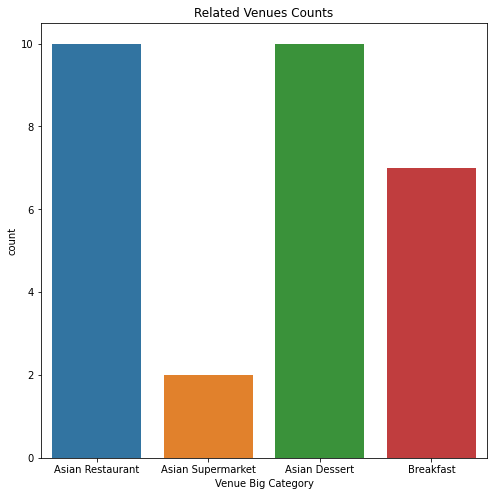

In [130]:
import warnings
warnings.filterwarnings("ignore")

Edison_Chinatown_Stelton_venues.loc[:,"Venue Big Category"] = Edison_Chinatown_Stelton_venues.loc[:, "Venue Category"]
Edison_Chinatown_Stelton_venues.loc[Edison_Chinatown_Stelton_venues["Venue Category"].isin(categories_restaurant),"Venue Big Category"] = "Asian Restaurant"
Edison_Chinatown_Stelton_venues.loc[Edison_Chinatown_Stelton_venues["Venue Category"].isin(categories_dessert),"Venue Big Category"] = "Asian Dessert"
Edison_Chinatown_Stelton_venues.loc[Edison_Chinatown_Stelton_venues["Venue Category"].isin(categories_breakfast),"Venue Big Category"] = "Breakfast"
Edison_Chinatown_Stelton_venues.loc[Edison_Chinatown_Stelton_venues["Venue Category"].isin(categories_supermarket),"Venue Big Category"] = "Asian Supermarket"
categories_food =["Asian Restaurant", "Asian Dessert", "Asian Supermarket", "Breakfast"]
plt.figure(figsize = (8,8))
sns.countplot(Edison_Chinatown_Stelton_venues[Edison_Chinatown_Stelton_venues["Venue Big Category"].isin(categories_food)]["Venue Big Category"])
plt.title("Related Venues Counts")
plt.show()


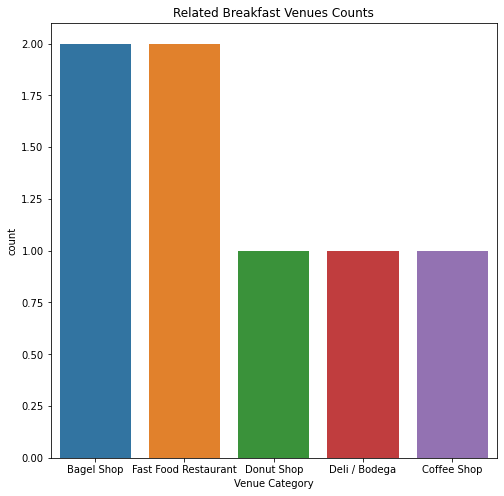

In [131]:
plt.figure(figsize = (8,8))
sns.countplot(Edison_Chinatown_Stelton_venues[Edison_Chinatown_Stelton_venues["Venue Big Category"]=="Breakfast"]["Venue Category"])
plt.title("Related Breakfast Venues Counts")
plt.show()


###There are seven venues that people can have breakfast in Stelton, but they are all American style. There is no Chinese style breakfast place in this neighborhood